# <font color='#0000CD'>Predicting Bitcoin Price in Real-Time with PySpark and Machine Learning</font>

### Model Goal: use historical data to train a Machine Learning model capable of predicting Bitcoin prices in real-time from new input data

* Included Records:
 * **OHLC (Open, High, Low, Close):** Represent the opening, highest, lowest, and closing daily prices of Bitcoin.
 * **Volume in BTC and Volume in USD:** Indicate the amount of Bitcoin traded and the corresponding volume in dollars.
 * **Weighted Price:** The weighted average of trading prices.
 * **Timestamp:** Date/Time in Unix format
 
#### Time Range: From 2011 to 2021, excluding the year 2022 due to its atypical nature.

#### The data can be found here:[dataset](https://bitcoincharts.com/charts/)

In [1]:
# Python version
from platform import python_version
print('Python version:', python_version())

Python version: 3.9.7


In [2]:
!pip install -q findspark

In [3]:
# Initialize pyspark
import findspark
findspark.init() 

In [4]:
# Imports
import pyspark
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
from pyspark import SparkConf, SparkContext
from pyspark.sql import SparkSession, SQLContext
from pyspark.sql.types import *
from pyspark.sql.functions import *
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.regression import LinearRegression
from pyspark.mllib.evaluation import RegressionMetrics
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import StringIndexer
from pyspark.ml.stat import Correlation
from pyspark.ml.feature import MinMaxScaler
from pyspark.ml.feature import VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator, CrossValidatorModel
from pyspark.ml.feature import VectorAssembler, StandardScaler
from pyspark.ml.evaluation import RegressionEvaluator

In [5]:
# Output formatting
pd.set_option('display.max_columns', 200)
pd.set_option('display.max_colwidth', 400)
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

In [6]:
from pyspark.sql import SparkSession

spark = SparkSession.builder \
    .master('local[*]') \
    .config("spark.driver.memory", "15g") \
    .appName('Bitcoint_Project') \
    .getOrCreate()

## Preparing the Spark Environment

In [7]:
# Defining random seed for notebook reproducibility
rnd_seed = 23
np.random.seed = rnd_seed
np.random.set_state = rnd_seed

In [8]:
# Creating Spark Context
sc = SparkContext.getOrCreate()

In [9]:
# Creating Spark Session
spark_session = SparkSession.Builder().getOrCreate()

In [10]:
spark_session

## Loading the Dataset

In [11]:
df_spark = spark_session.read.csv('data/dataset.csv', header = 'true', inferSchema = 'true')

In [12]:
# Object type
type(df_spark)

pyspark.sql.dataframe.DataFrame

In [13]:
df_spark.show()

+----------+----+----+----+-----+------------+-----------------+--------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|
+----------+----+----+----+-----+------------+-----------------+--------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325319660| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345040| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|
|1325345100| NaN| NaN| NaN|  NaN|       

In [14]:
# Visualize metadata (schema)
df_spark.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- Volume_(BTC): double (nullable = true)
 |-- Volume_(Currency): double (nullable = true)
 |-- Weighted_Price: double (nullable = true)



In [15]:
df_spark.count()

4856600

## Data Wrangling with SparkSQL

In [16]:
# Create a temporary table from the dataframe
# Temporary tables are used so that the result set is visible for all other Spark sessions
df_spark.createOrReplaceTempView('bitcoin_data') 

In [17]:
# SQL function
df_bitcoin = spark_session.sql("select *, from_unixtime(Timestamp) as `dateTime` from bitcoin_data")

In [18]:
type(df_bitcoin)

pyspark.sql.dataframe.DataFrame

In [19]:
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325319300| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:15:00|
|1325319360| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:16:00|
|1325319420| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:17:00|
|1325319480| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:18:00|
|1325319540| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:19:00|
|1325319600| NaN| NaN| NaN|  NaN|         NaN|              NaN|           NaN|2011-12-31 06:20:00|


In [20]:
# Removing NA values (there is no sense in any treatment here, as all quote columns are as NA)
df_bitcoin = df_bitcoin.dropna('any')

In [21]:
df_bitcoin.show()

+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|Volume_(BTC)|Volume_(Currency)|Weighted_Price|           dateTime|
+----------+----+----+----+-----+------------+-----------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39|  0.45558087|     2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|        48.0|           210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57| 37.86229723|     171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|         9.0|            41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|       1.502|          6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|        10.0|             48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|        10.1|             50.5|           5.0|2012-01-01 20:45:00|


In [22]:
df_bitcoin.count()

3613769

In [23]:
# Renaming columns for easier manipulation
df_bitcoin = df_bitcoin.withColumnRenamed("Volume_(BTC)", "VolBTC").withColumnRenamed("Volume_(Currency)", "VolCurrency")

In [24]:
df_bitcoin.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:28:00|
|1325457900| 5.0| 5.0| 5.0|  5.0|       10.1|        50.5|           5.0|2012-01-01 20:45:00|
|1325534640| 5.0| 5.0| 5.0|  5.0|     19.048|       95.24|  

In [25]:
# Splitting the dataframe extracting the date
df_date = df_bitcoin.withColumn("date", split(col("dateTime")," ").getItem(0))

In [26]:
type(df_date)

pyspark.sql.dataframe.DataFrame

In [27]:
# Extracting the time
df_date = df_date.withColumn("time", split(col("dateTime")," ").getItem(1))

In [28]:
# Schema
df_date.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)



In [29]:
df_date.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01 13:2

In [30]:
# Extracting the hour
df_date_hour = df_date.withColumn("hour", split(col("time"),":").getItem(0))

In [31]:
df_date_hour.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)
 |-- date: string (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: string (nullable = true)



In [32]:
df_date_hour.show()

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|           dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31 05:52:00|2011-12-31|05:52:00|  05|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31 13:50:00|2011-12-31|13:50:00|  13|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31 14:59:00|2011-12-31|14:59:00|  14|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31 15:00:00|2011-12-31|15:00:00|  15|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01 02:16:00|2012-01-01|02:16:00|  02|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|   

In [33]:
# Adjusting the date format to extract the day of the week
df_date_hour = df_date_hour.withColumn("date", df_date_hour["date"].cast(DateType())).withColumn("hour", df_date_hour["hour"].cast(DoubleType())).withColumn("dateTime", df_date_hour["dateTime"].cast(DateType()))


In [34]:
df_date_hour.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|
|1325431680|4.84|4.84|4.84| 4.84|       10.0|        48.4|          4.84|2012-01-01|2012-01-01|13:28:00|13.0|
|132545790

In [35]:
# Extracting the day of the week
df_date_hour = df_date_hour.withColumn('day_of_week', dayofweek(df_date_hour.date))

In [36]:
df_date_hour.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: date (nullable = true)
 |-- date: date (nullable = true)
 |-- time: string (nullable = true)
 |-- hour: double (nullable = true)
 |-- day_of_week: integer (nullable = true)



In [37]:
# Extracting the year 
df_date_hour_year = df_date_hour.withColumn("year", split(col("date"),"-").getItem(0))

In [38]:
df_date_hour_year.show()

+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
| Timestamp|Open|High| Low|Close|     VolBTC| VolCurrency|Weighted_Price|  dateTime|      date|    time|hour|day_of_week|year|
+----------+----+----+----+-----+-----------+------------+--------------+----------+----------+--------+----+-----------+----+
|1325317920|4.39|4.39|4.39| 4.39| 0.45558087|2.0000000193|          4.39|2011-12-31|2011-12-31|05:52:00| 5.0|          7|2011|
|1325346600|4.39|4.39|4.39| 4.39|       48.0|      210.72|          4.39|2011-12-31|2011-12-31|13:50:00|13.0|          7|2011|
|1325350740| 4.5|4.57| 4.5| 4.57|37.86229723|171.38033753|  4.5264114983|2011-12-31|2011-12-31|14:59:00|14.0|          7|2011|
|1325350800|4.58|4.58|4.58| 4.58|        9.0|       41.22|          4.58|2011-12-31|2011-12-31|15:00:00|15.0|          7|2011|
|1325391360|4.58|4.58|4.58| 4.58|      1.502|     6.87916|          4.58|2012-01-01|2012-01-01|02:16:00| 2.0|  

In [39]:
# If there is an error in the next cell, you can use this SQL function to use 3 years and reduce memory usage
# Just remove the ''' at the beggining and end

'''

df_date_hour_year.createOrReplaceTempView('df_filtered')


query = """

SELECT *

FROM df_filtered

WHERE year IN (

SELECT DISTINCT year

FROM df_filtered

ORDER BY year DESC

LIMIT 3

)

"""


df_filtered = spark_session.sql(query)


df_pandas = df_filtered.toPandas()


'''

'\n\ndf_date_hour_year.createOrReplaceTempView(\'df_filtered\')\n\n\nquery = """\n\nSELECT *\n\nFROM df_filtered\n\nWHERE year IN (\n\nSELECT DISTINCT year\n\nFROM df_filtered\n\nORDER BY year DESC\n\nLIMIT 3\n\n)\n\n"""\n\n\ndf_filtered = spark_session.sql(query)\n\n\ndf_pandas = df_filtered.toPandas()\n\n\n'

In [40]:
# Converting the Spark dataframe to Pandas to facilitate exploratory analysis.
df_pandas = df_date_hour_year.toPandas()

In [41]:
type(df_pandas)

pandas.core.frame.DataFrame

In [42]:
# Getting the individual values to use in the graphs
hour = df_pandas["hour"].values.tolist()
weighted_price = df_pandas["Weighted_Price"].values.tolist()
volume_BTC = df_pandas["VolBTC"].values.tolist()
date_of_week = df_pandas["day_of_week"].values.tolist()
year = df_pandas["year"].values.tolist()

## Exploratory Analysis

<AxesSubplot:>

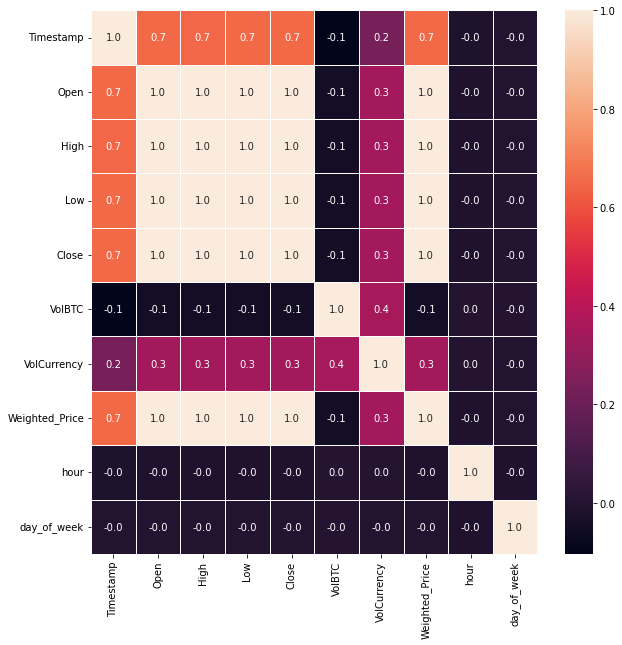

In [43]:
# Heatmap to visualize the correlation
corr = df_pandas.corr()                                                # Calculate the coefficients
f,ax = plt.subplots(figsize = (10, 10))                                # Create the plot area
sns.heatmap(corr, annot = True, linewidths = .5, fmt = '.1f', ax = ax) # Create the graph in the plot area

Ideally we want high correlation between the input variables and the output variable and low correlation between the input variables!    

**Input Variable:** Weighted_Price

<Figure size 864x360 with 0 Axes>

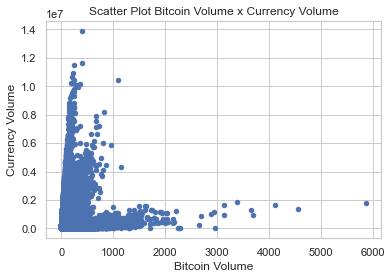

In [44]:
# Scatter Plot Bitcoin Volume x Currency Volume
plt.figure(figsize = (12,5))
sns.set(style = 'whitegrid')
df_pandas.plot(kind = 'scatter', x = 'VolBTC', y = 'VolCurrency')
plt.xlabel('Bitcoin Volume')            
plt.ylabel('Currency Volume')
plt.title('Scatter Plot Bitcoin Volume x Currency Volume') 
plt.show()

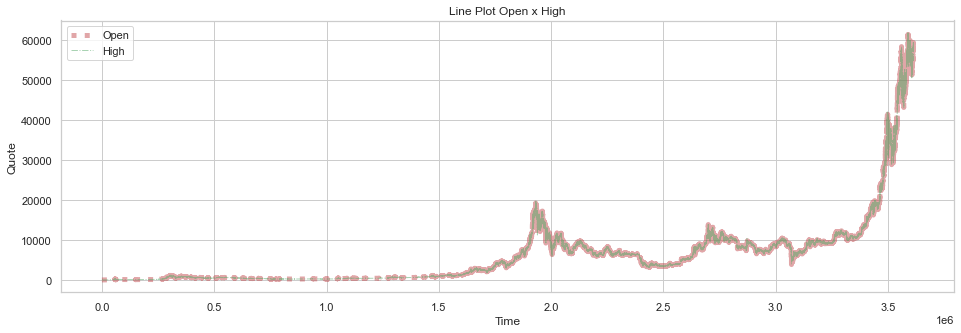

In [45]:
# Line Plot Open x High 
plt.figure(figsize = (16,5))
df_pandas.Open.plot(kind = 'line', 
                    color = 'r', 
                    label = 'Open', 
                    alpha = 0.5, 
                    linewidth = 5, 
                    grid = True, 
                    linestyle = ':')
df_pandas.High.plot(color = 'g', 
                    label = 'High', 
                    linewidth = 1, 
                    alpha = 0.5, 
                    grid = True, 
                    linestyle = '-.')
plt.legend(loc = 'upper left') 
plt.xlabel('Time')
plt.ylabel('Quote')
plt.title('Line Plot Open x High')
plt.show()

<AxesSubplot:ylabel='Frequency'>

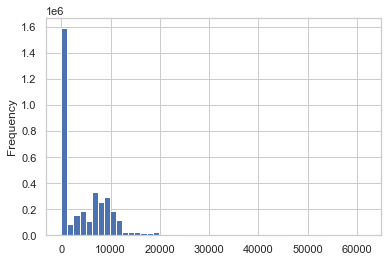

In [46]:
# Opening quote histogram
df_pandas.Open.plot(kind = 'hist', bins = 50)

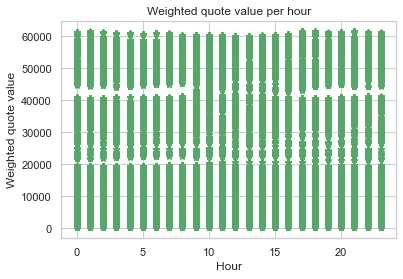

In [47]:
# Plot of weighted quote value (target variable) per hour
plt.plot(hour, weighted_price , 'g*')
plt.xlabel('Hour')            
plt.ylabel('Weighted quote value')
plt.title('Weighted quote value per hour') 
plt.show()

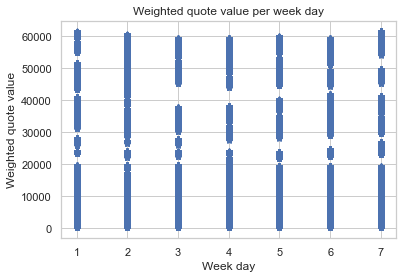

In [48]:
# Weighted quote value per week day
plt.plot(date_of_week, weighted_price, 'b*')
plt.xlabel('Week day')            
plt.ylabel('Weighted quote value')
plt.title('Weighted quote value per week day') 
plt.show()

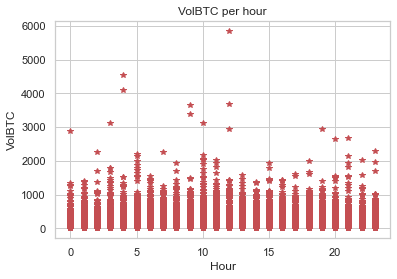

In [49]:
# VolBTC per hour
plt.plot(hour, volume_BTC, 'r*')
plt.xlabel('Hour')            
plt.ylabel('VolBTC')
plt.title('VolBTC per hour') 
plt.show()

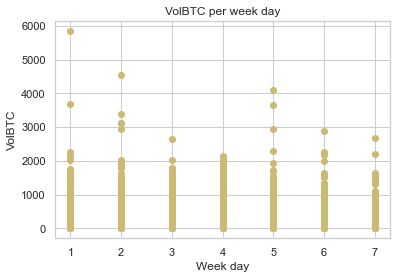

In [50]:
# VolBTC per week day
plt.plot(date_of_week, volume_BTC, 'yo')
plt.xlabel('Week day')            
plt.ylabel('VolBTC')
plt.title('VolBTC per week day') 
plt.show()

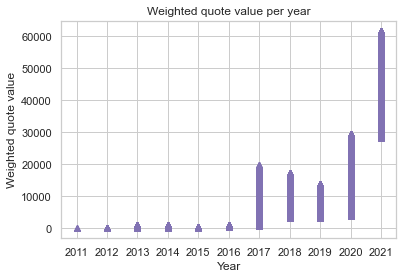

In [51]:
# Weighted quote value per year
plt.plot(year, weighted_price , 'm^')
plt.xlabel('Year')            
plt.ylabel('Weighted quote value')
plt.title('Weighted quote value per year') 
plt.show()

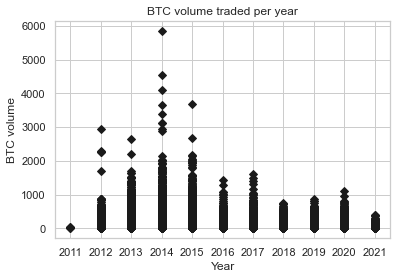

In [52]:
# Volume per year
plt.plot(year, volume_BTC , 'kD')
plt.xlabel('Year')            
plt.ylabel('BTC volume')
plt.title('BTC volume traded per year') 
plt.show()

## Attribute Engineering with PySpark

In [53]:
df_bitcoin.printSchema()

root
 |-- Timestamp: integer (nullable = true)
 |-- Open: double (nullable = true)
 |-- High: double (nullable = true)
 |-- Low: double (nullable = true)
 |-- Close: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)
 |-- Weighted_Price: double (nullable = true)
 |-- dateTime: string (nullable = true)



In [54]:
# Prepara o vetor de atributos
# We will use "open" because generally there is a high volume of transactions
# Pyspark needs the input variables to be in feature vector format to create the predictive model
assembler = VectorAssembler(inputCols = ['Open', 'VolBTC', 'VolCurrency'], 
                            outputCol = "features")

In [55]:
# Create the feature vector dataframe
df_assembled = assembler.transform(df_bitcoin)

In [56]:
df_assembled.show(10, truncate = False)

+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|Timestamp |Open|High|Low |Close|VolBTC     |VolCurrency |Weighted_Price|dateTime           |features                      |
+----------+----+----+----+-----+-----------+------------+--------------+-------------------+------------------------------+
|1325317920|4.39|4.39|4.39|4.39 |0.45558087 |2.0000000193|4.39          |2011-12-31 05:52:00|[4.39,0.45558087,2.0000000193]|
|1325346600|4.39|4.39|4.39|4.39 |48.0       |210.72      |4.39          |2011-12-31 13:50:00|[4.39,48.0,210.72]            |
|1325350740|4.5 |4.57|4.5 |4.57 |37.86229723|171.38033753|4.5264114983  |2011-12-31 14:59:00|[4.5,37.86229723,171.38033753]|
|1325350800|4.58|4.58|4.58|4.58 |9.0        |41.22       |4.58          |2011-12-31 15:00:00|[4.58,9.0,41.22]              |
|1325391360|4.58|4.58|4.58|4.58 |1.502      |6.87916     |4.58          |2012-01-01 02:16:00|[4.58,1.502,6.87916]          |


## Normalization

In [57]:
# Splitting into training and testing data
training_data, test_data = df_assembled.randomSplit([.7,.3], seed = rnd_seed)

In [58]:
type(training_data)

pyspark.sql.dataframe.DataFrame

In [59]:
# Creates scaler
scaler = MinMaxScaler(inputCol = "features", outputCol = "scaled_features")

In [60]:
# Fit training data
scalerModel = scaler.fit(training_data)

In [61]:
# Fit and transform training data
training_data_scaled = scalerModel.transform(training_data)

In [62]:
# Transform testing data
test_data_scaled = scalerModel.transform(test_data)

In [63]:
training_data_scaled.select("features", "scaled_features").show(10, truncate = False)

+-------------------------------+------------------------------------------------------------------+
|features                       |scaled_features                                                   |
+-------------------------------+------------------------------------------------------------------+
|[4.39,48.0,210.72]             |[9.557729822093386E-6,0.011673503471190906,1.8335460613525925E-5] |
|[4.5,37.86229723,171.38033753] |[1.1339679449941311E-5,0.00920803454461806,1.4912383393669768E-5] |
|[4.58,9.0,41.22]               |[1.263564281564889E-5,0.0021887819008482947,3.58669175441125E-6]  |
|[4.84,10.0,48.4]               |[1.6847523754198516E-5,0.0024319798898314385,4.211447863015635E-6]|
|[5.0,10.1,50.5]                |[1.9439450485613674E-5,0.002456299688729753,4.3941759727745785E-6]|
|[5.14,0.68,3.4952]             |[2.170738637560193E-5,1.6537463250853785E-4,3.041291853473605E-7] |
|[5.26,29.31939163,154.21999997]|[2.36513314241633E-5,0.00713041708262522,1.341920432454396

In [64]:
training_data_scaled.columns

['Timestamp',
 'Open',
 'High',
 'Low',
 'Close',
 'VolBTC',
 'VolCurrency',
 'Weighted_Price',
 'dateTime',
 'features',
 'scaled_features']

## Machine Learning

In [65]:
# Regression model
model_lr_v1 = (LinearRegression(featuresCol = 'scaled_features',      # Input variables
                                labelCol = "Weighted_Price",          # Output variable
                                predictionCol = 'Predicted_price',    # Prediction column
                                maxIter = 100,                        # Maximum number of iterations
                                regParam = 0.3,                       # Regression parameter
                                elasticNetParam = 0.8,                # Model regularization to avoid overfitting
                                standardization = False))             # Data already standardized 

In [66]:
# Train the model
model_v1 = model_lr_v1.fit(training_data_scaled)

In [67]:
# Save the model
# model_v1.write().overwrite().save("models/model_v1")

## Model Evaluation

In [68]:
# Previsões com dados de teste
predictions_v1 = model_v1.transform(test_data_scaled)

In [69]:
# Seleciona as colunas
pred_data_v1 = predictions_v1.select("Predicted_price", "Weighted_Price").show(10)

+-----------------+--------------+
|  Predicted_price|Weighted_Price|
+-----------------+--------------+
|7.452551600540269|          4.39|
|7.642451952582102|          4.58|
|8.062231678148258|           5.0|
|8.382063850008189|          5.32|
| 8.35207958389632|          5.29|
| 8.35207958389632|          5.29|
|8.252132030190092|          5.19|
| 8.42204287149068|  5.3604618117|
|8.811838330944967|   5.777027027|
|9.061707215210538|           6.0|
+-----------------+--------------+
only showing top 10 rows



In [70]:
# Mean Absolute Error
print("Mean Absolute Error (MAE): {0}".format(model_v1.summary.meanAbsoluteError))

Mean Absolute Error (MAE): 5.021578949826644


In [71]:
# Create an evaluator for the regression model
evaluator = RegressionEvaluator(labelCol = "Weighted_Price", 
                                predictionCol = "Predicted_price", 
                                metricName = "rmse")

In [72]:
# Apply the evaluator
rmse_v1 = evaluator.evaluate(predictions_v1)
print("Root Mean Squared Error (RMSE): %g" % rmse_v1)

Root Mean Squared Error (RMSE): 11.3089


In [73]:
# Extract the predictions
pred_results_v1 = model_v1.evaluate(test_data_scaled)

In [74]:
# Real Y values being converted to Pandas format
Y = pred_results_v1.predictions.select('Weighted_Price').toPandas()

In [75]:
# Predicted Y values being converted to Pandas format
_Y = pred_results_v1.predictions.select("Predicted_price").toPandas()

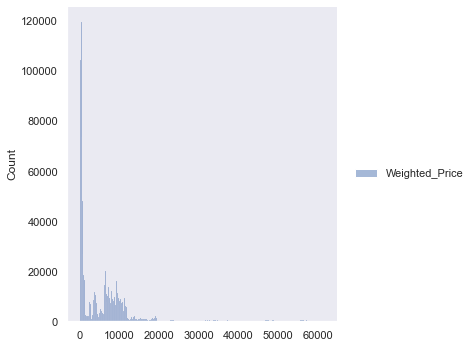

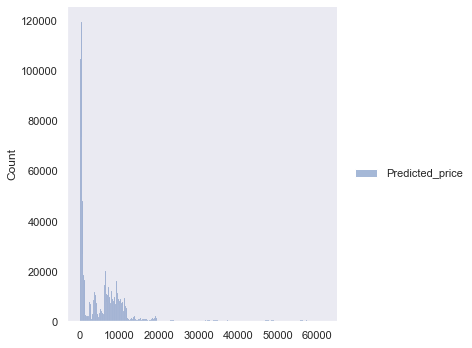

In [76]:
# Distribution of real values x predicted values
sns.set_style("dark")
ax1 = sns.displot(Y, color = "r", label = "Real Values")
sns.displot(_Y, color = "b", label = "Predicted values")

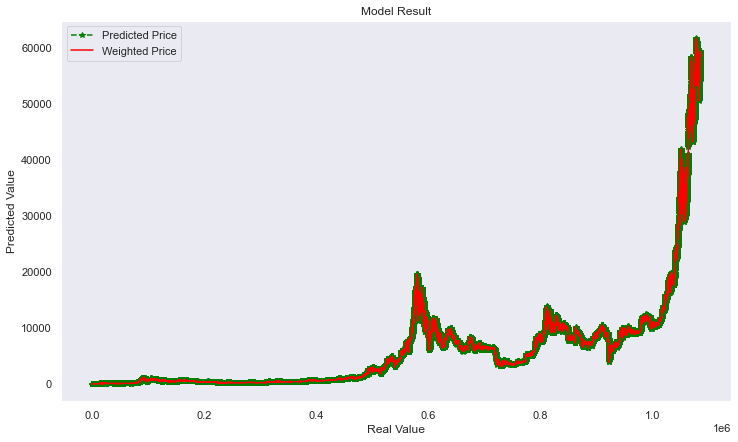

In [77]:
# Plot of actual values x predicted values
plt.figure(figsize = (12,7))
plt.plot(Y, color = 'green', marker = '*', linestyle = 'dashed', label = 'Predicted Price')
plt.plot(_Y, color = 'red', label = 'Weighted Price')
plt.title('Model Result')
plt.xlabel('Real Value')
plt.ylabel('Predicted Value')
plt.legend()

## Predictions in Real Time

In [78]:
# New data
new_data = [[20546.29, 3422.57, 72403082.02], [21620.85, 3271.14, 71319207.5]]

In [79]:
# Prepare the Pandas dataframe
df_new_data = pd.DataFrame(new_data, columns = ['Open', 'VolBTC', 'VolCurrency'])

In [80]:
df_new_data

,Open,VolBTC,VolCurrency
0,20546.29,3422.57,72403082.02
1,21620.85,3271.14,71319207.50


In [81]:
# Convert Pandas dataframe to Spark dataframe
df_new_data_spark = spark_session.createDataFrame(df_new_data) 

In [82]:
# Schema
df_new_data_spark.printSchema()

root
 |-- Open: double (nullable = true)
 |-- VolBTC: double (nullable = true)
 |-- VolCurrency: double (nullable = true)



In [83]:
df_new_data_spark.show()

+--------+-------+-------------+
|    Open| VolBTC|  VolCurrency|
+--------+-------+-------------+
|20546.29|3422.57|7.240308202E7|
|21620.85|3271.14| 7.13192075E7|
+--------+-------+-------------+



In [84]:
# Create the attribute vector dataframe
df_assembled = assembler.transform(df_new_data_spark)

In [85]:
df_assembled.show()

+--------+-------+-------------+--------------------+
|    Open| VolBTC|  VolCurrency|            features|
+--------+-------+-------------+--------------------+
|20546.29|3422.57|7.240308202E7|[20546.29,3422.57...|
|21620.85|3271.14| 7.13192075E7|[21620.85,3271.14...|
+--------+-------+-------------+--------------------+



In [86]:
# Normalize data
df_assembled_scaled = scalerModel.transform(df_assembled)

In [87]:
# Predictions with new data
predictions = model_v1.transform(df_assembled_scaled)

In [88]:
pred_data = predictions.select("Predicted_price").show()

+------------------+
|   Predicted_price|
+------------------+
|20538.579086380156|
|21612.575519485796|
+------------------+



In [89]:
# Close the Spark session
spark_session.stop()

# Fim